In [1]:
import random
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import minmax_scale
import matplotlib.pyplot as plt
from network import NeuralNetwork

In [2]:
# random.seed(9001)

df = pd.read_excel('HW3train.xlsx')
x0 = df['X_0']
x1 = df['X_1']
y = df['y'].tolist()
training_sets = []
for i in range(len(x0)):
    training_sets.append([[x0[i], x1[i]], [y[i]]])

df = pd.read_excel('HW3validate.xlsx')
x0 = df['X_0']
x1 = df['X_1']
y = df['y'].tolist()
validation_sets = []
for i in range(len(x0)):
    validation_sets.append([[x0[i], x1[i]], [y[i]]])


# for the plots ------------------------------
x_epochs = [] # epochs on the x-axis
y_train = [] # mse train
y_val = [] # mse validation
# --------------------------------------------

In [3]:
nn = NeuralNetwork(len(training_sets[0][0]), 10, 10, len(training_sets[0][1]))
BATCH_SIZE = 32
epochs = 0
iterations = 0

In [4]:
if BATCH_SIZE > 0:
    while epochs < 10:
        nn.train(training_sets[BATCH_SIZE*iterations:BATCH_SIZE+BATCH_SIZE*iterations])
        y_train.append(nn.calculate_total_error(training_sets))
        y_val.append(nn.calculate_total_error(validation_sets))
        x_epochs.append(epochs)
        iterations += 1
        if iterations % (math.ceil(len(training_sets) / BATCH_SIZE)) == 0:
            iterations = 0
            epochs += 1
        

In [5]:
def plots():
    plt.plot(x_epochs, y_train, label='Training')
#     plt.plot(x_epochs, y_val, label='Validation')

    plt.xlabel('Epochs')
    plt.ylabel('MSE')

    plt.title("Plot of MSE over training and validation data")

    plt.legend()

    plt.show()

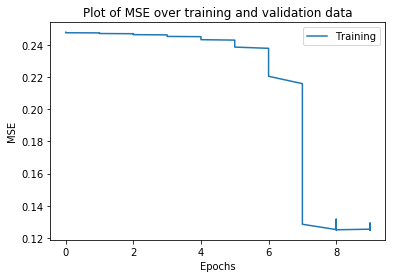

In [6]:
plots() # with mini-batches

In [7]:
# without mini batches
while epochs < 250:
    nn.train(training_sets)
    y_train.append(nn.calculate_total_error(training_sets))
    y_val.append(nn.calculate_total_error(validation_sets))
    x_epochs.append(epochs)
    epochs += 1
# nn.undo()

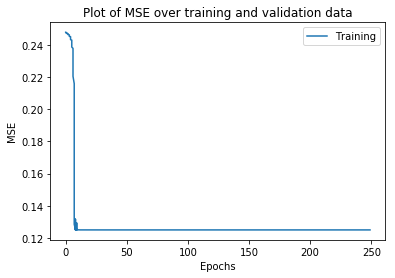

In [8]:
plots()